# 2.6  Coordinate search and descent

- The coordinate search and descent algorithms are additional zero order local methods that get around the inherent scaling issues of random  search by restricting the set of search directions to the coordinate axes of the input space.  


- The concept is simple: random search was designed to minimize a function $g\left(w_1,w_2,...,w_N\right)$ with respect to all of its parameters *simultaneously*.  


- With coordinate wise algorithms we attempt to minimize such a function with respect to one coordinate or weight at a time - or more generally one subset of coordinates or weights at a time - keeping all others fixed.


- While this limits the diversity of descent directions that can be potentially discovered, and thus more steps are often required to determine approximate minima, these algorithms are far more scalable than random search.  

- Additionally  - as was the case with the random search approach - these algorithms serve as predicates for an entire thread of higher order *coordinate descent methods* we will see in the next few Chapters.  


- Through understanding coordinate search / descent in the comparatively simpler zero order framework we are currently in we lay the ground work for better understanding of this entire suite of powerful coordinate-based algorithms.

- You can toggle the code on and off in this presentation via the button below.

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
# This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
import numpy as np
from datetime import datetime 
static_plotter = optlib.static_plotter.Visualizer();
optimizers = optlib.optimizers

# This is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

## Searching through the coordinate axes

- The *coordinate search* algorithm takes the theme of descent direction search and - instead of searching randomly - restricts the set of directions to the coordinate axes of the input space alone.  


- While this significantly limits the kinds of descent directions we can recover it far more scalable than seeking out a good descent direction at random, and opens the search-approach to determining descent directions to usage with higher dimensional input functions.

- As illustrated in the Figure below for an $N$ = 2 dimensional example, with coordinate search we seek out the best descent direction among only the coordinate axes of the input space.  


- This means in general that for a function of input dimension $N$ we only look over $2N$ directions - the positive and negative versions of each coordinate input.  


- As with the random local search algorithm we will use unit-length directions, meaning that at every step the set of directions we search over always consists of just positive and negative versions of the *standard basis*.  

<img src= '../../mlrefined_images/math_optimization_images/coordinate_search.png' width="105%" height="100%"/>

- In an $N$ dimensional input space the $n^{th}$ standard basis vector - denoted $\mathbf{e}_n$ -  is just a vector of all zeros whose $n^{th}$ entry is set to $1$.  


- Searching only over the positive and negative set of these directions means at the $k^{th}$ step of this local method we search only over the set of $2N$ candidate directions $\left\{\pm \, \mathbf{e}_n \right\}_{n=1}^N$ for the best descent direction (if one exists).  

- This means - in particular - each pair of candidate points using a single standard basis direction looks like

\begin{equation}
\mathbf{w}_{\text{candidate}} = \mathbf{w}^{k-1} \pm \alpha \mathbf{e}_n.
\end{equation}

- It is this restricted set of directions we are searching over that distinguishes the coordinate search approach from the random search approach described in the previous Section, where the set of directions at each step was made up of random directions. 


- While the diversity of the coordinate axes may limit the effectiveness of the possible descent directions it can encounter and thus require more steps to determine an approximate minimum, the restricted search makes coordinate search far more scalable than the random search method since at each step only $2N$ directions must be tested.

## Zero-order coordinate descent

- A slight twist on the coordinate search produces a much more effective algorithm at precisely the same computational cost.  


- Instead of collecting each coordinate direction (along with its negative), and then choosing a single best direction from this entire set, we can simply examine one coordinate direction (and its negative) at a time and step in this direction if it produces descent.  

- Whereas with coordinate search we evaluate the cost function $2N$ times (once per coordinate direction and its negative) to produce a single step, this alternative takes the same number of function evaluations but potentially moves $N$ steps in doing so.  


- In other words this means that for precisely the same cost as coordinate search we can (potentially) descent much faster with coordinate descent.

<img src= '../../mlrefined_images/math_optimization_images/zero_order_coordinate_descent.png' width="95%" height="100%"/>

- This twist on the coordinate search approach is called a *coordinate descent*, since each step evaluates a single coordinate direction and decides whether or not to move in this direction alone.  


- This particular algorithm - while itself being the most effective zero order method we have seen thus far by far - is a predicate for many useful coordinate descent approaches we will see in future Chapters as well.

In [7]:
# This code cell will not be shown in the HTML version of this notebook
# zero order coordinate search
def coordinate_descent_zero_order(g,alpha_choice,max_its,w):  
    # run coordinate search
    N = np.size(w)
    weight_history = []         # container for weight history
    cost_history = []           # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):        
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # random shuffle of coordinates
        c = np.random.permutation(N)
        
        # forming the dirction matrix out of the loop
        cost = g(w)
        
        # loop over each coordinate direction
        for n in range(N):
            direction = np.zeros((N,1)).flatten()
            direction[c[n]] = 1
     
            # record weights and cost evaluation
            weight_history.append(w)
            cost_history.append(cost)

            # evaluate all candidates
            evals =  [g(w + alpha*direction)]
            evals.append(g(w - alpha*direction))
            evals = np.array(evals)

            # if we find a real descent direction take the step in its direction
            ind = np.argmin(evals)
            if evals[ind] < cost_history[-1]:
                # take step
                w = w + ((-1)**(ind))*alpha*direction
                cost = evals[ind]
        
    # record weights and cost evaluation
    weight_history.append(w)
    cost_history.append(g(w))
    return weight_history,cost_history

#### <span style="color:#a50e3e;">Example. </span>  Coordinate search versus coordinate descent

- In this example we compare the efficacy of coordinate search and the coordinate descent algorithm described above using the same function from the previous example.  



- Here we compare $20$ steps of coordinate search (left panel) and coordinate descent (right panel), using a diminishing step length for both runs.  


- Because coordinate descent takes two steps for every single step taken by coordinate search we get significantly closer to the function minimum.

<IPython.core.display.Javascript object>


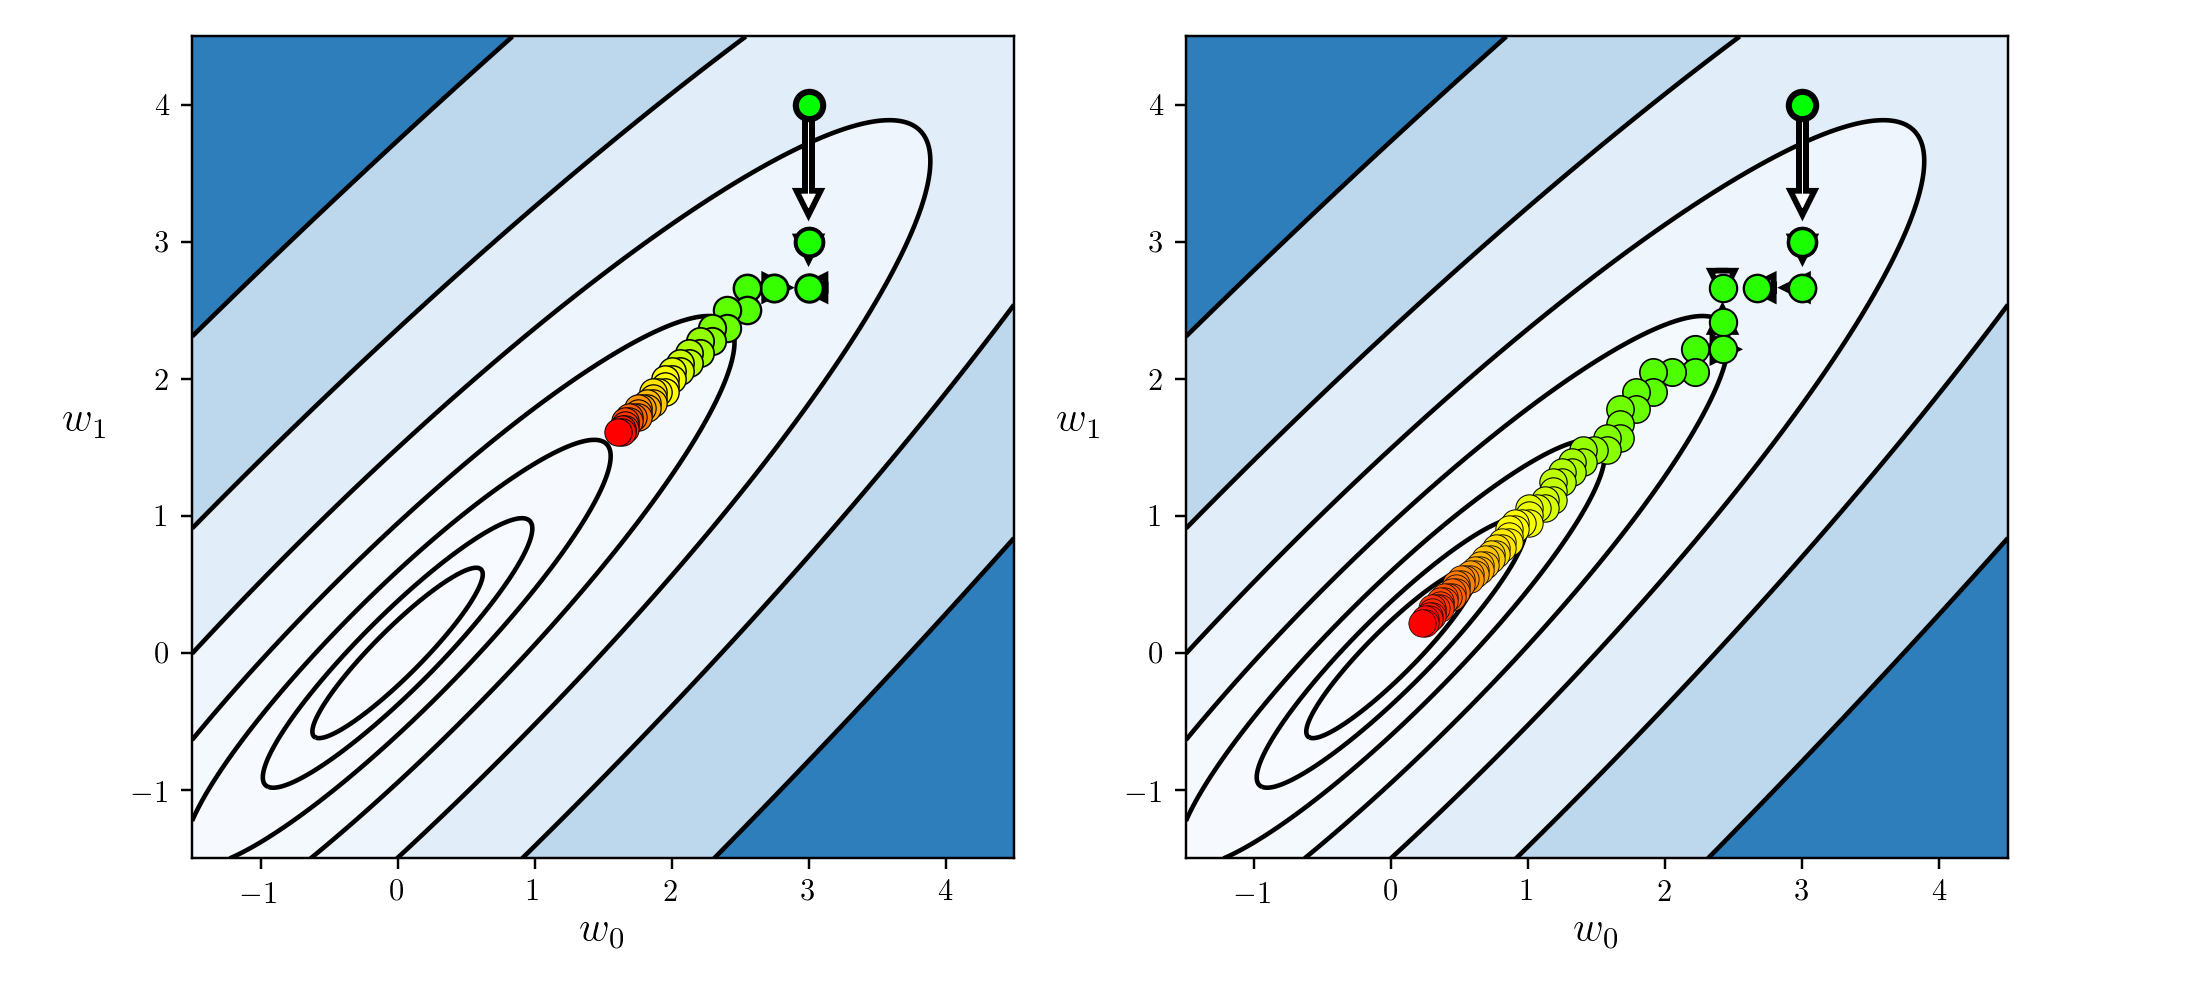

In [8]:
# This code cell will not be shown in the HTML version of this notebook
# define function
g = lambda w: 0.26*(w[0]**2 + w[1]**2) - 0.48*w[0]*w[1]

# run coordinate search algorithm 
alpha_choice = 'diminishing'; w = np.array([3,4]); max_its = 40;
weight_history_1,cost_history_1 = coordinate_search(g,alpha_choice,max_its,w)

# run coordinate descent algorithm
alpha_choice = 'diminishing'; w = np.array([3,4]); max_its = 40;
weight_history_2,cost_history_2 = coordinate_descent_zero_order(g,alpha_choice,max_its,w)

# show run in both three-dimensions and just the input space via the contour plot
static_plotter.compare_runs_contour_plots(g,[weight_history_1,weight_history_2],xmin = -1.5,xmax = 4.5,ymin = -1.5,ymax = 4.5,num_contours = 7)

- We can view the precise difference more easily by comparing the two function evaluation histories via the cost function history plot, which we do below.  


- Here we can see in this instance while the first several steps of coordinate search were more effective than their descent counterparts (since they search over the entire list of coordinate directions instead of one at a time), the coordinate descent method quickly overtakes search finding a lower point on the cost function.

<IPython.core.display.Javascript object>


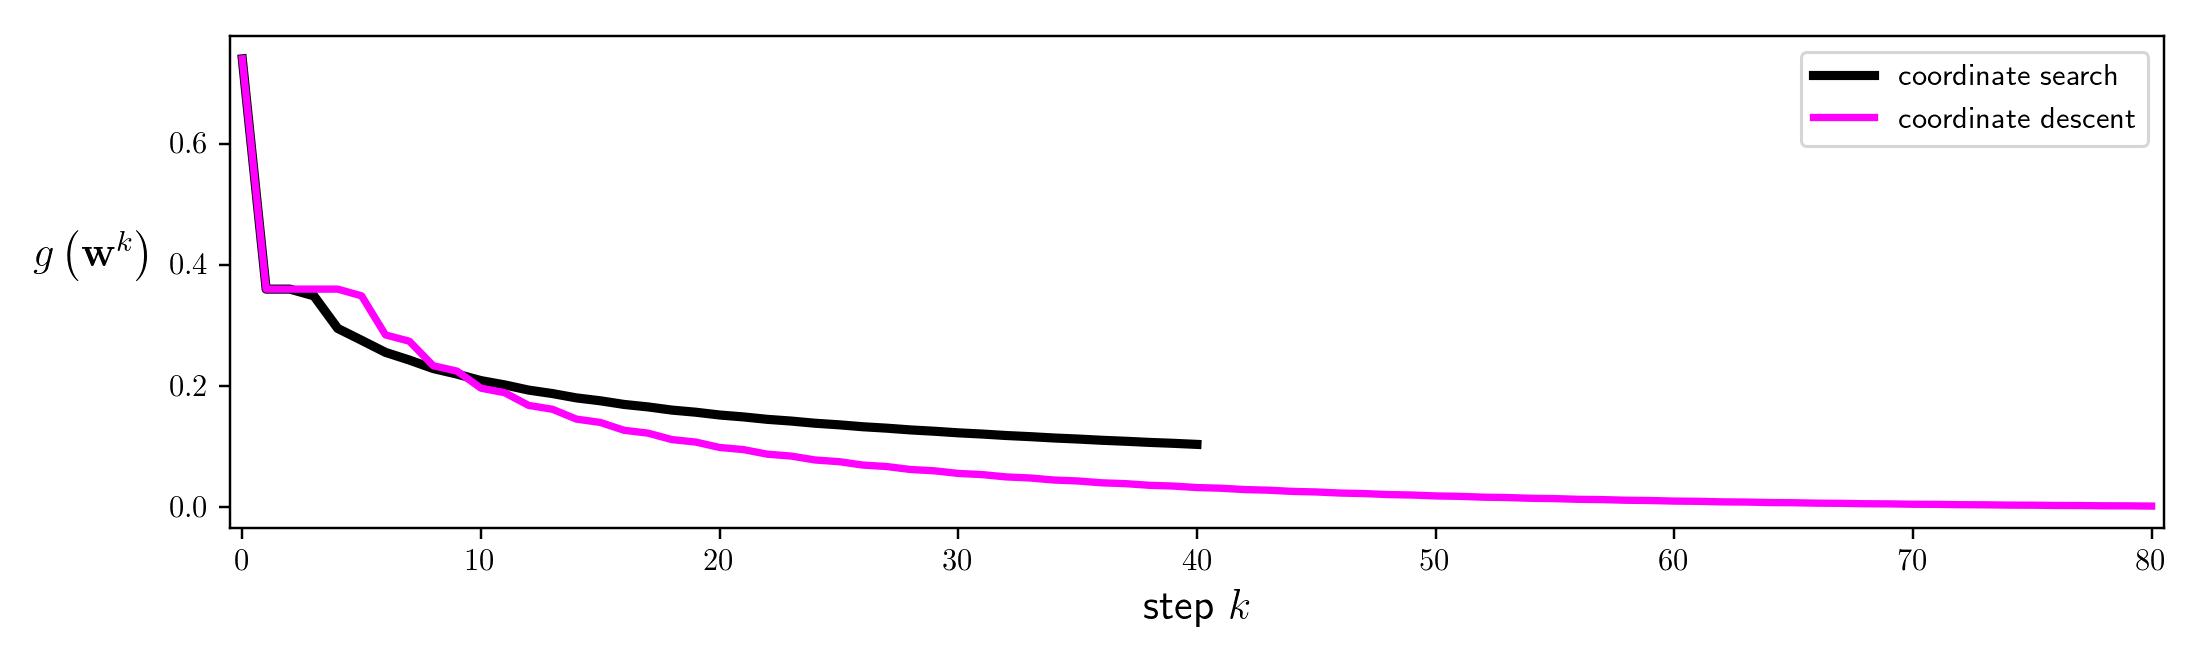

In [9]:
# This code cell will not be shown in the HTML version of this notebook
# plot the cost function history for a given run
static_plotter.plot_cost_histories([cost_history_1,cost_history_2],start = 0,points = False,labels = ['coordinate search','coordinate descent'])

<IPython.core.display.Javascript object>


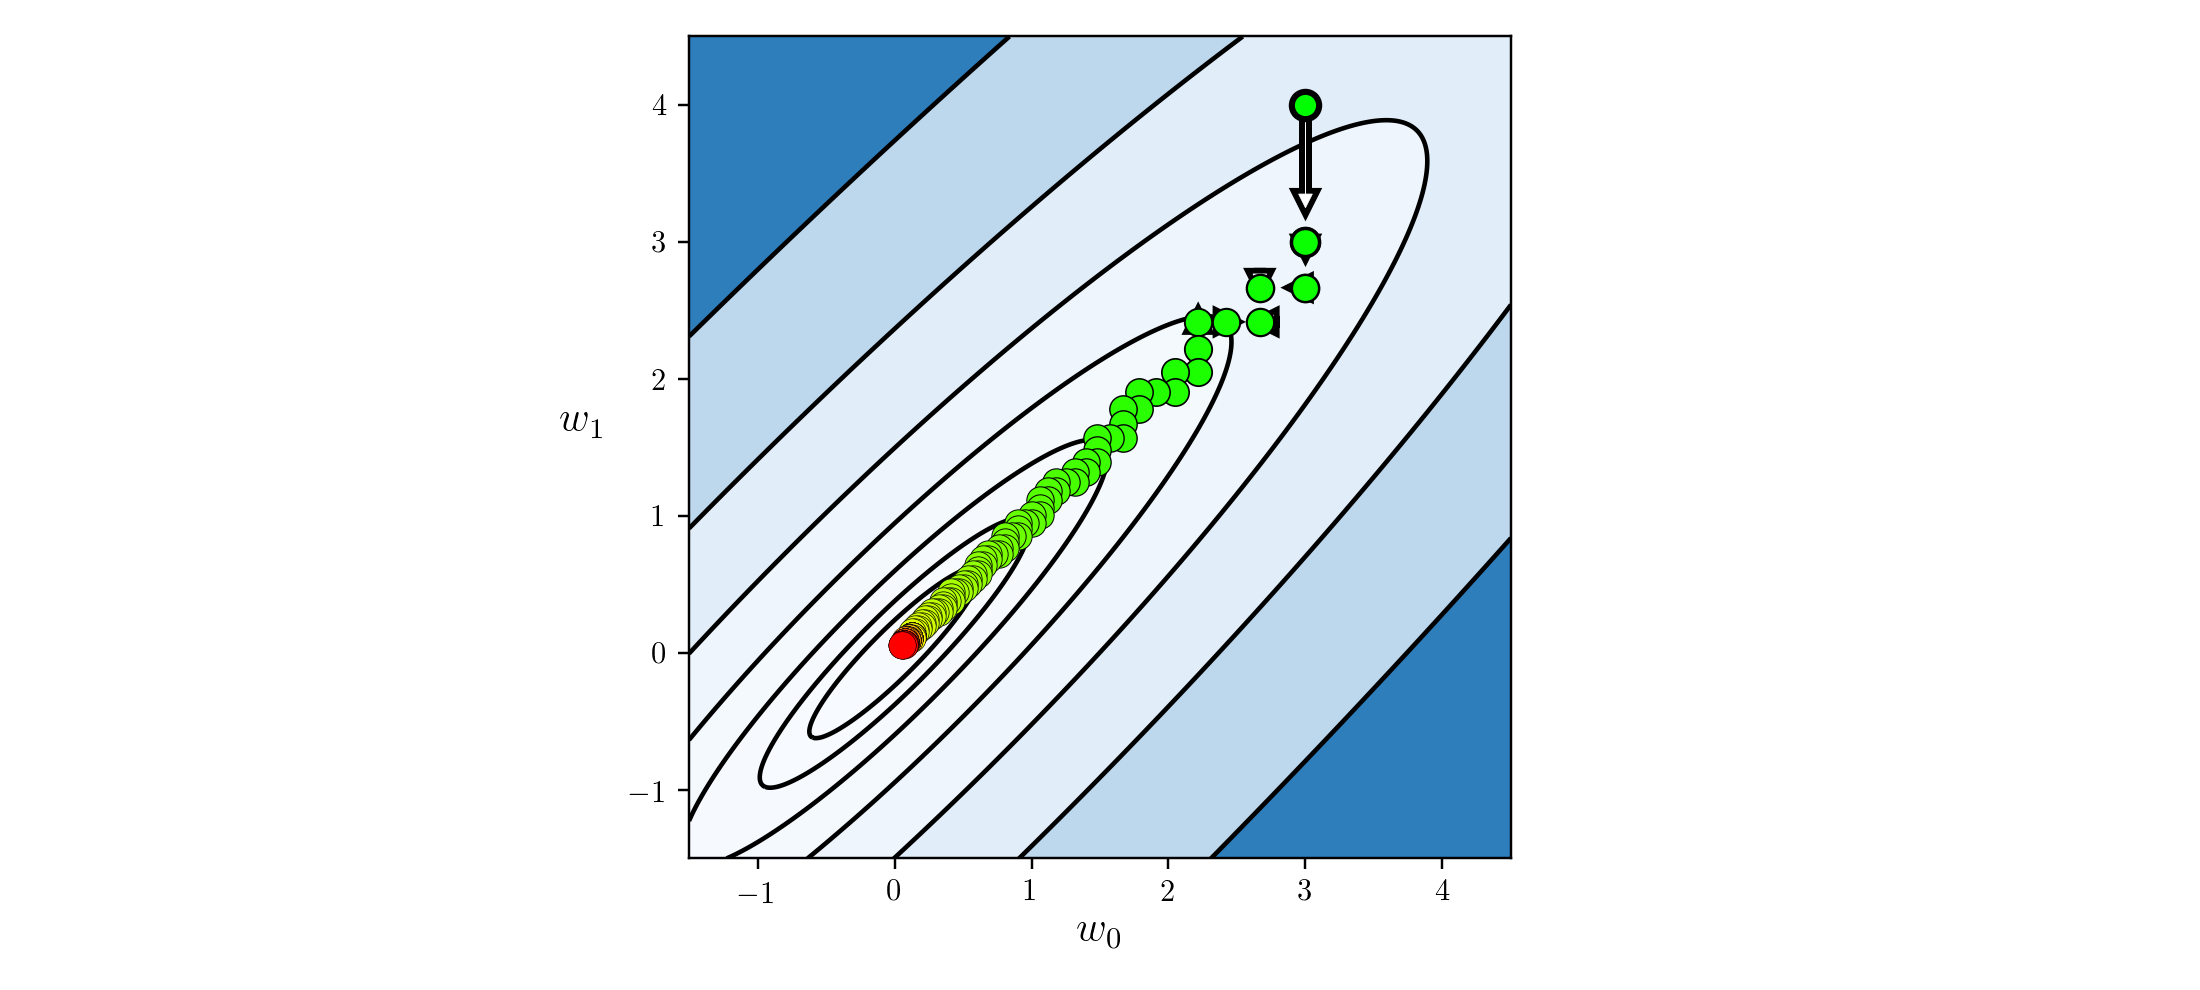

In [10]:
# This code cell will not be shown in the HTML version of this notebook
# define function
g = lambda w: 0.26*(w[0]**2 + w[1]**2) - 0.48*w[0]*w[1]

# run coordinate search algorithm 
alpha_choice = 'diminishing'; w = np.array([3,4]); max_its = 100;
weight_history,cost_history = coordinate_descent_zero_order(g,alpha_choice,max_its,w)

# show run in both three-dimensions and just the input space via the contour plot
static_plotter.two_input_contour_plot(g,weight_history,xmin = -1.5,xmax = 4.5,ymin = -1.5,ymax = 4.5,num_contours = 7,show_original = False)